<a href="https://colab.research.google.com/github/AmDeep/AI_LaunchLab_Team3/blob/main/Data_preprocessing_LT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Getting the data out of xarray

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import xarray as xa
from torch.utils.data import DataLoader, TensorDataset, Dataset


In [2]:
!pip install netcdf4

This is preprocessing for now, can be run anywhere

In [3]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          26124         828       24312           1         983       24951
Swap:             0           0           0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
INPUT_FILE = 'drive/MyDrive/Data/Climate/SR/super_resolution.nc'

In [6]:
d = xa.open_dataset(INPUT_FILE, group='/train/x') 
data_y=xa.open_dataset(INPUT_FILE, group='/train/y')

In [7]:
d_val = xa.open_dataset(INPUT_FILE, group='/val/x') 
data_y_val=xa.open_dataset(INPUT_FILE, group='/val/y')

In [8]:
kept_vars = d.drop_vars(['time', 'h', 'mg_delta', 'me_delta', 'zp_delta', 'vg_delta', 'td', 'pn', 'nt', 'rt', 'i4', '5p', 'i6'])
kept_vars_val = d_val.drop_vars(['time', 'h', 'mg_delta', 'me_delta', 'zp_delta', 'vg_delta', 'td', 'pn', 'nt', 'rt', 'i4', '5p', 'i6'])

In [9]:
kept_vars

<xarray.Dataset>
Dimensions:  (time: 5343, x: 256, y: 256)
Dimensions without coordinates: time, x, y
Data variables:
    tt       (time, x, y) float32 ...
    uu       (time, x, y) float32 ...
    vv       (time, x, y) float32 ...

In [10]:
x = np.array(kept_vars.to_array())
y = np.array(data_y.to_array())
x_val = np.array(kept_vars_val.to_array())
y_val = np.array(data_y_val.to_array())

In [11]:
x.shape

(3, 5343, 256, 256)

In [12]:
x_val.shape

(3, 1000, 256, 256)

In [13]:
def shape_data(x, y):
  x = x.transpose(1, 2, 3, 0)
  y= y.transpose(1,2,3,0)
  x_tens=torch.tensor(x, dtype=torch.float)
  y_tens=torch.tensor(y, dtype=torch.float) 
  x_tens= x_tens.permute(0,3,1,2)
  y_tens= y_tens.permute(0,3,1,2)

  return x_tens, y_tens

In [14]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [15]:
def crop_images(x_tens, y_tens, x_features=3):
  #input has to be x.shape: torch.Size([ 20, x_features,256, 256])
                #  y.shape: torch.Size([20, 1, 256, 256])
  new_images=[]
  x_tens=x_tens.permute(1,0,2,3)
  #tensor=torch.tensor(dtype=torch.float)
  

  #For each feature of x (ex:tt, uu, vv etc..) crop image and then organize it in a tensor
  for i in range(x_features):
    new_images=[]
    for img in x_tens[i][:]:
          image=crop_center(img,cropx=64,cropy=64)
          image=np.array(image)
          new_images.append(image)

    new_images=np.array(new_images)
   # print(new_images.shape)
    new_x_tens=torch.tensor(new_images, dtype=torch.float).unsqueeze(1)
    if i==0:
      x_tensor=new_x_tens
    else:
      x_tensor=torch.cat((x_tensor, new_x_tens), 1)

 # DO the same for y 
  new_images=[]

  for img in y_tens.squeeze():
        image=crop_center(img,cropx=64,cropy=64)
        image=np.array(image)
        new_images.append(image)
      
  new_images=np.array(new_images)
  #print(new_images.shape)
  y_tensor=torch.tensor(new_images, dtype=torch.float).unsqueeze(1)
    
  return x_tensor, y_tensor



In [16]:
x_tensor,y_tensor=shape_data(x,y)
x_tensor_val,y_tensor_val=shape_data(x_val,y_val)

In [17]:
y_tensor.shape

torch.Size([4343, 1, 256, 256])

In [18]:
y_tensor_val.shape

torch.Size([1000, 1, 256, 256])

In [19]:
cropped_x, cropped_y= crop_images(x_tensor,y_tensor, x_features=3)
cropped_x_val, cropped_y_val= crop_images(x_tensor_val,y_tensor_val, x_features=3)

cropped_x=cropped_x/255
cropped_y=cropped_y/255
cropped_x_val=cropped_x_val/255
cropped_y_val=cropped_y_val/255

In [20]:
def display_images(x, x_hat, num_im=1, label=None):
    x= x.permute(1,0,2,3)
    x=x[0][:]
    for N in range(num_im):
        if x is not None:
            x_im = x.data.cpu().view(-1, 64, 64)
            fig = plt.figure(figsize=(18, 4))
            fig.suptitle(' Value of the first layer in the second dimension (tt) - input image', fontsize=12)
    #        plt.subtitle(label + ' – initial image / reconstructed image', color='black', fontsize=12)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(x_im[i+4*N])
                #plt.axis('off')
        x_hat_im = x_hat.data.cpu().view(-1, 64, 64)
        fig = plt.figure(figsize=(18, 4))
        fig.suptitle(' Value of the first layer in the second dimension (tt) - high res image', fontsize=12)
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(x_hat_im[i+4*N])
            #plt.axis('off')

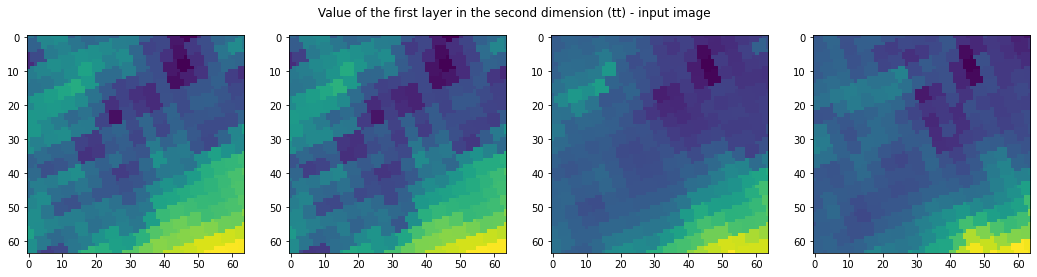

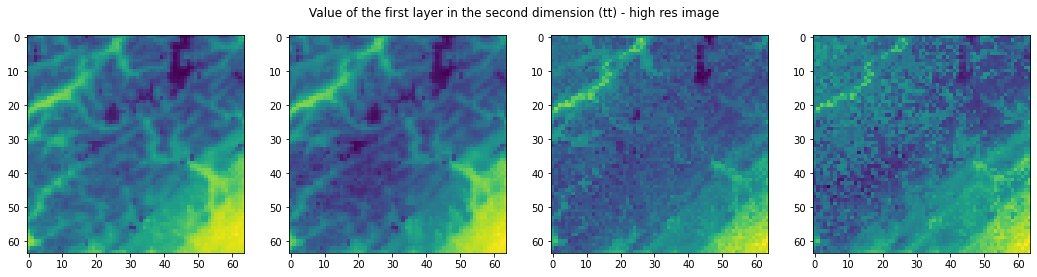

In [21]:
 display_images(cropped_x_val, cropped_y_val, num_im=1, label=None )

In [22]:
d.close()
data_y.close()
d_val.close()
data_y_val.close()

In [23]:
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [24]:
cropped_y.shape

torch.Size([4343, 1, 64, 64])

In [25]:
cropped_x = cropped_x[:4343]

In [26]:
full_data_x= torch.cat((cropped_x, cropped_x_val), 0)

full_data_y= torch.cat((cropped_y, cropped_y_val), 0)



In [29]:
full_data_x.shape

torch.Size([5343, 3, 64, 64])

In [30]:
full_dataset= TensorDataset(full_data_x, full_data_y)

In [32]:
batch_size=32
dataset_size = len(full_dataset)
train_dataset_size = int(dataset_size * 0.8)
valid_dataset_size = int(dataset_size * 0.2)
test_dataset_size = dataset_size - (train_dataset_size + valid_dataset_size)
        
[train_dataset, valid_dataset, test_dataset] = torch.utils.data.random_split(full_dataset, [train_dataset_size, valid_dataset_size, test_dataset_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [26]:
#train_dataset= TensorDataset(cropped_x, cropped_y)
#val_dataset= TensorDataset(cropped_x_val, cropped_y_val)


torch.Size([32, 3, 64, 64])
tensor([[[-0.0341, -0.0341, -0.0391,  ..., -0.0432, -0.0327, -0.0327],
         [-0.0391, -0.0391, -0.0391,  ..., -0.0381, -0.0381, -0.0435],
         [-0.0391, -0.0391, -0.0391,  ..., -0.0381, -0.0381, -0.0435],
         ...,
         [-0.0360, -0.0360, -0.0360,  ..., -0.0034, -0.0024, -0.0024],
         [-0.0360, -0.0360, -0.0360,  ..., -0.0034, -0.0024, -0.0024],
         [-0.0360, -0.0360, -0.0360,  ..., -0.0034, -0.0034, -0.0024]],

        [[ 0.0402,  0.0402,  0.0339,  ...,  0.0292,  0.0369,  0.0369],
         [ 0.0339,  0.0339,  0.0339,  ...,  0.0307,  0.0307,  0.0252],
         [ 0.0339,  0.0339,  0.0339,  ...,  0.0307,  0.0307,  0.0252],
         ...,
         [ 0.0426,  0.0426,  0.0426,  ...,  0.0508,  0.0538,  0.0538],
         [ 0.0426,  0.0426,  0.0426,  ...,  0.0508,  0.0538,  0.0538],
         [ 0.0426,  0.0426,  0.0426,  ...,  0.0508,  0.0508,  0.0538]],

        [[-0.0592, -0.0592, -0.0641,  ..., -0.0779, -0.0779, -0.0779],
         [-0.0641

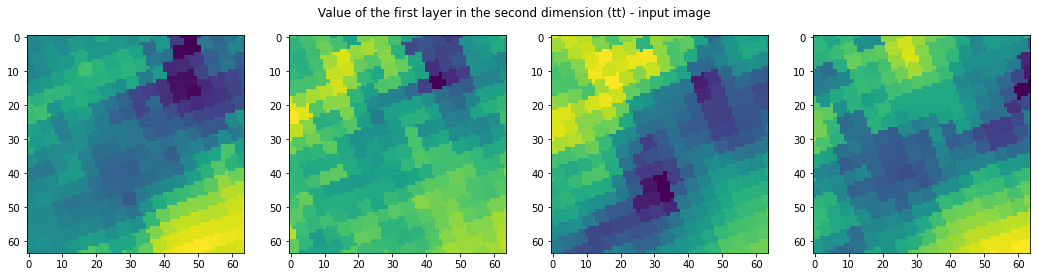

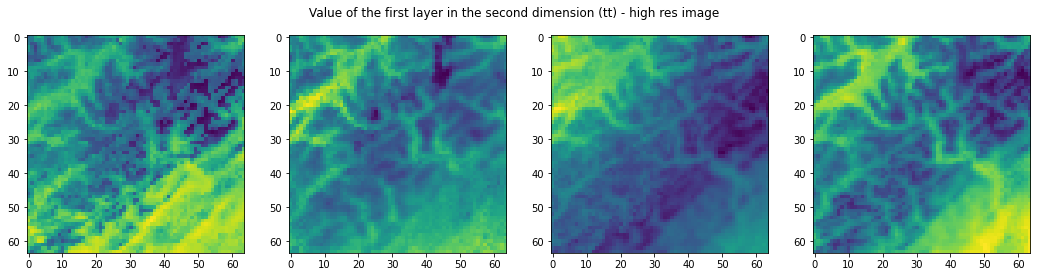

In [33]:
#train_dataset= TensorDataset(cropped_x, cropped_y)
#batch_size=32 # should be 32 with all the data
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

for x, y in train_loader:
  print(x.shape)
  display_images(x, y, num_im=1, label=None )
  print(x.permute(1,0,2,3)[0])

  break

In [34]:
pip install GPUtil


In [35]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [36]:
import gc
def delete_Variables():
  del globals()['x']
  del globals()['y']
  del globals()['x_val']
  del globals()['y_val']
  del globals()['x_tensor']
  del globals()['y_tensor']
  del globals()['x_tensor_val']
  del globals()['y_tensor_val']
  del globals()['cropped_x']
  del globals()['cropped_y']
  del globals()['cropped_x_val']
  del globals()['cropped_y_val']
  gc.collect()

In [37]:
delete_Variables()

SR GAN IMPLEMENTATION

In [63]:

import os
import torch
import torch.nn as n
import torch.nn as nn
import torch.nn.functional as f
import numpy as np
import os
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torchvision import models
import cv2
from matplotlib import pyplot as plt
from PIL import Image

In [115]:
class Generator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,9,padding=4,bias=False)
        self.conv2 = n.Conv2d(64,64,3,padding=1,bias=False)
        self.conv3_1 = n.Conv2d(64,64,3,padding=1,bias=False)
        self.conv3_2 = n.Conv2d(64,64,3,padding=1,bias=False)
        self.conv4 = n.Conv2d(64,1,9,padding=4,bias=False)
        self.bn = n.BatchNorm2d(64)
        self.ps = n.PixelShuffle(1)
        self.prelu = n.PReLU()
        
    def forward(self,x):
        block1 = self.prelu(self.conv1(x))
        block2 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block1))))),block1)
     #   block3 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block2))))),block2)
     #   block4 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block3))))),block3)
     #   block5 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block2))))),block2)
     #   block6 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block5))))),block5)
        block7 = torch.add(self.bn(self.conv2(block2)),block1)
   #     block8 = self.prelu(self.ps(self.conv3_1(block7)))
   #     block9 = self.prelu(self.ps(self.conv3_2(block7)))
        block10 = self.conv4(block7)
        return block10

In [116]:
gen = Generator().cuda()

#Uncomment below mentioned three lines if you have more than one gpu and want to use all of them
#ngpu=2
# if (cuda.type == 'cuda') and (ngpu > 1):
#     gen = n.DataParallel(gen, list(range(ngpu)))
summary(gen,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]          15,552
             PReLU-2           [-1, 64, 64, 64]               1
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
             PReLU-5           [-1, 64, 64, 64]               1
            Conv2d-6           [-1, 64, 64, 64]          36,864
       BatchNorm2d-7           [-1, 64, 64, 64]             128
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10            [-1, 1, 64, 64]           5,184
Total params: 131,714
Trainable params: 131,714
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 18.03
Params size (MB): 0.50
Estimated 

In [125]:
class Discriminator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(1,64,3,padding=1,bias=False)
        self.conv2 = n.Conv2d(64,64,3,stride=2,padding=1,bias=False)
        self.bn2 = n.BatchNorm2d(64)
        self.conv3 = n.Conv2d(64,128,3,padding=1,bias=False)
        self.bn3 = n.BatchNorm2d(128)
    #    self.conv4 = n.Conv2d(128,128,3,stride=2,padding=1,bias=False)
    #    self.bn4 = n.BatchNorm2d(128)
        self.conv5 = n.Conv2d(128,256,3,padding=1,bias=False)
        self.bn5 = n.BatchNorm2d(256)
   #     self.conv6 = n.Conv2d(256,256,3,stride=2,padding=1,bias=False)
   #     self.bn6 = n.BatchNorm2d(256)
        self.conv7 = n.Conv2d(256,512,3,padding=1,bias=False)
        self.bn7 = n.BatchNorm2d(512)
        self.conv8 = n.Conv2d(512,512,3,stride=2,padding=1,bias=False)
        self.bn8 = n.BatchNorm2d(512)
        self.fc1 = n.Linear(512*16*16,1024)
        self.fc2 = n.Linear(1024,1)
        self.drop = n.Dropout2d(0.3)
        
    def forward(self,x):
        block1 = f.leaky_relu(self.conv1(x))
        block2 = f.leaky_relu(self.bn2(self.conv2(block1)))
        block3 = f.leaky_relu(self.bn3(self.conv3(block2)))
      #  block4 = f.leaky_relu(self.bn4(self.conv4(block3)))
        block5 = f.leaky_relu(self.bn5(self.conv5(block3)))
    #    block6 = f.leaky_relu(self.bn6(self.conv6(block5)))
        block7 = f.leaky_relu(self.bn7(self.conv7(block5)))
        block8 = f.leaky_relu(self.bn8(self.conv8(block7)))
        block8 = block8.view(-1,block8.size(1)*block8.size(2)*block8.size(3))
        block9 = f.leaky_relu(self.fc1(block8),)
#         block9 = block9.view(-1,block9.size(1)*block9.size(2)*block9.size(3))
        block10 = torch.sigmoid(self.drop(self.fc2(block9)))
        return block9,block10

In [126]:
disc = Discriminator().cuda()
summary(disc,(1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]             576
            Conv2d-2           [-1, 64, 32, 32]          36,864
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,728
       BatchNorm2d-5          [-1, 128, 32, 32]             256
            Conv2d-6          [-1, 256, 32, 32]         294,912
       BatchNorm2d-7          [-1, 256, 32, 32]             512
            Conv2d-8          [-1, 512, 32, 32]       1,179,648
       BatchNorm2d-9          [-1, 512, 32, 32]           1,024
           Conv2d-10          [-1, 512, 16, 16]       2,359,296
      BatchNorm2d-11          [-1, 512, 16, 16]           1,024
           Linear-12                 [-1, 1024]     134,218,752
           Linear-13                    [-1, 1]           1,025
        Dropout2d-14                   

In [127]:

disc = Discriminator().cuda().float()
gen = Generator().cuda().float()

In [128]:
vgg = models.vgg16(pretrained=True).cuda()
#vgg=Net().cuda()

In [129]:
gen_loss = n.BCELoss()
vgg_loss = n.MSELoss()
mse_loss = n.MSELoss()
disc_loss = n.BCELoss()

In [130]:
gen_optimizer = optim.Adam(gen.parameters(),lr=0.0001)
disc_optimizer = optim.Adam(disc.parameters(),lr=0.0001)

In [131]:
EPOCHS=10

In [ ]:
for epoch in range(EPOCHS):

  d1loss_list=[]
  d2loss_list=[]
  gloss_list=[]
  vloss_list=[]
  mloss_list=[]
  gen.train()
  disc.train()
  vgg.train()
  for lr_images, hr_images in train_loader:
        
        lr_images = lr_images.cuda()
        hr_images = hr_images.cuda()

        disc.zero_grad()

        gen_out = gen(lr_images)
  #      print(gen_out.shape)
        _,f_label = disc(gen_out)
        _,r_label = disc(hr_images)

        #d1 loss is the loss for the fake input.
        d1_loss = (disc_loss(f_label,torch.zeros_like(f_label,dtype=torch.float)))
        #d2 loss is the loss for the real input.
        d2_loss = (disc_loss(r_label,torch.ones_like(r_label,dtype=torch.float)))
        # d_loss = d1_loss+d2_loss
        d2_loss.backward()
        d1_loss.backward(retain_graph=True)
        # print(d1_loss,d2_loss)
#         d_loss.backward(retain_graph=True)
        disc_optimizer.step()
        

        gen.zero_grad()      
        g_loss = gen_loss(f_label.data,torch.ones_like(f_label,dtype=torch.float))

        ### Just concatenating the output to feed the VGG net
        gen_out_vgg=torch.cat((gen_out, gen_out), 1)
        gen_out_vgg=torch.cat((gen_out_vgg, gen_out), 1)
        hr_images_vgg=torch.cat((hr_images, hr_images), 1)
        hr_images_vgg=torch.cat((hr_images_vgg, hr_images), 1)
    #    print(gen_out_vgg.shape)
     #   print(hr_images_vgg.shape)
        v_loss = vgg_loss(vgg.features[:7](gen_out_vgg),vgg.features[:7](hr_images_vgg))
 #      v_loss = vgg_loss(vgg(gen_out),vgg(hr_images))
        m_loss = mse_loss(gen_out,hr_images)
        
        generator_loss = g_loss + v_loss + m_loss
        # v_loss.backward(retain_graph=True)
        # m_loss.backward(retain_graph=True)
        # g_loss.backward()
        # print(generator_loss)

        generator_loss.backward()
        gen_optimizer.step()
        
        d1loss_list.append(d1_loss.item())
        d2loss_list.append(d2_loss.item())
        
        gloss_list.append(g_loss.item())
        vloss_list.append(v_loss.item())
        mloss_list.append(m_loss.item())
    
  print(" TRAIN Epoch ::::  "+str(epoch+1)+"  d1_loss ::: "+str(np.mean(d1loss_list))+"  d2_loss :::"+str(np.mean(d2loss_list)))
  print(" TRAIN genLoss ::: "+str(np.mean(gloss_list))+"  vggLoss ::: "+str(np.mean(vloss_list))+"  MeanLoss  ::: "+str(np.mean(mloss_list)))



  with torch.no_grad():
    gen.eval()
    disc.eval()
    vgg.eval()
    d1loss_list_val=[]
    d2loss_list_val=[]
    gloss_list_val=[]
    vloss_list_val=[]
    mloss_list_val=[]

    for lr_images_val, hr_images_val in val_loader:

      lr_images_val = lr_images_val.cuda()
      hr_images_val = hr_images_val.cuda()
      gen_out_val = gen(lr_images_val)

      _,f_label_val = disc(gen_out_val)
      _,r_label_val = disc(hr_images_val)

      #d1 loss is the loss for the fake input.
      d1_loss_val = (disc_loss(f_label_val,torch.zeros_like(f_label_val,dtype=torch.float)))
      #d2 loss is the loss for the real input.
      d2_loss_val = (disc_loss(r_label_val,torch.ones_like(r_label_val,dtype=torch.float)))

      g_loss_val = gen_loss(f_label_val.data,torch.ones_like(f_label_val,dtype=torch.float))

      ### Just concatenating the output to feed the VGG net
      gen_out_vgg_val=torch.cat((gen_out_val, gen_out_val), 1)
      gen_out_vgg_val=torch.cat((gen_out_vgg_val, gen_out_val), 1)
      hr_images_vgg_val=torch.cat((hr_images_val, hr_images_val), 1)
      hr_images_vgg_val=torch.cat((hr_images_vgg_val, hr_images_val), 1)

      v_loss_val = vgg_loss(vgg.features[:7](gen_out_vgg_val),vgg.features[:7](hr_images_vgg_val))
 #    v_loss = vgg_loss(vgg(gen_out),vgg(hr_images))
      m_loss_val = mse_loss(gen_out_val,hr_images_val)
        
      generator_loss = g_loss_val + v_loss_val + m_loss_val

      d1loss_list_val.append(d1_loss_val.item())
      d2loss_list_val.append(d2_loss_val.item())
        
      gloss_list_val.append(g_loss_val.item())
      vloss_list_val.append(v_loss_val.item())
      mloss_list_val.append(m_loss_val.item())

  print("VAL Epoch ::::  "+str(epoch+1)+"  d1_loss ::: "+str(np.mean(d1loss_list_val))+"  d2_loss :::"+str(np.mean(d2loss_list_val)))
  print("VAL genLoss ::: "+str(np.mean(gloss_list_val))+"  vggLoss ::: "+str(np.mean(vloss_list_val))+"   MEAN SQUARED ERROR VALIDATION  ::: "+str(np.mean(mloss_list_val)))
  print("")

  if(epoch%5==0):

    display_images(gen_out_val, hr_images_val, num_im=1, label=None )
    display_images(gen_out, hr_images, num_im=1, label=None)


 TRAIN Epoch ::::  1  d1_loss ::: 0.250696173688369  d2_loss :::0.3732093141706132
 TRAIN genLoss ::: 16.27270871222909  vggLoss ::: 0.1663725834006249  MeanLoss  ::: 0.012549695365761629
VAL Epoch ::::  1  d1_loss ::: 0.0  d2_loss :::0.5519963117206798
VAL genLoss ::: 84.5389819425695  vggLoss ::: 0.013868178049211992   MEAN SQUARED ERROR VALIDATION  ::: 0.0071844796937726

 TRAIN Epoch ::::  2  d1_loss ::: 0.21143578048517456  d2_loss :::0.20759046984030238
 TRAIN genLoss ::: 28.403060030581347  vggLoss ::: 0.012244366842613959  MeanLoss  ::: 0.0007713654472965247
VAL Epoch ::::  2  d1_loss ::: 0.0  d2_loss :::0.0001560830872469577
VAL genLoss ::: 47.03331666834214  vggLoss ::: 0.011160258340704091   MEAN SQUARED ERROR VALIDATION  ::: 0.0049397742293555945

 TRAIN Epoch ::::  3  d1_loss ::: 0.21401096646910284  d2_loss :::0.21068546631887777
 TRAIN genLoss ::: 24.068891468332776  vggLoss ::: 0.008029260954110702  MeanLoss  ::: 0.0005936239599102566
VAL Epoch ::::  3  d1_loss ::: 0.0 

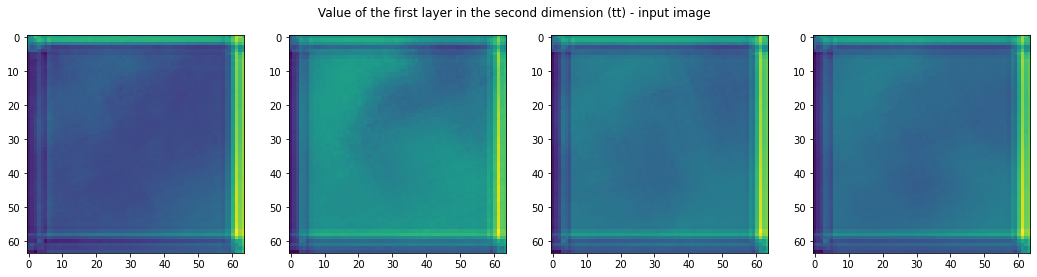

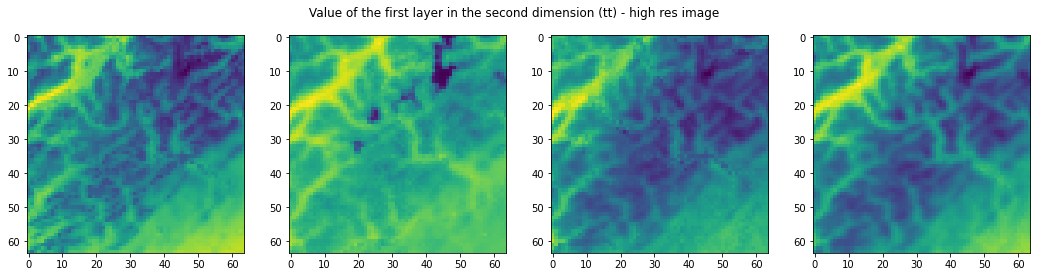

In [ ]:
for lr_images, hr_images in train_loader:
  lr_images = lr_images.cuda()
  hr_images = hr_images.cuda()


  gen_out = gen(lr_images)




  display_images(gen_out, hr_images, num_im=1, label=None )
  #print(gen_out.permute(1,0,2,3)[0])

  break